## Пятое решение
В этом решении предлагается в архитектуру нейронной сети добавить механизм внимания, предполагается, что он будет подмечать мелкие и редкие детали.

In [1]:
import re
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import chain
from torch import nn, optim
import albumentations as albu
from catalyst.metrics import iou
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from catalyst.contrib.losses import DiceLoss, IoULoss
from albumentations.pytorch import ToTensorV2 as ToTensor
from catalyst.callbacks import (DiceCallback, 
                                IOUCallback, 
                                CriterionCallback,
                                MetricAggregationCallback, 
                                OptimizerCallback)
from utils import(create_sample, 
                  extract_ids, 
                  split_sample, 
                  PascalDataset, 
                  visualize, 
                  PascalRunner,
                  plot_metric,
                  extract_masks, 
                  extract_masks_label)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
src_path = Path("Pascal-part")
image_path = src_path / "JPEGImages"
mask_path = src_path / "gt_masks"

image_names = create_sample(image_path)
mask_names = create_sample(mask_path)

In [4]:
train_ids = extract_ids(src_path / "train_id.txt")
val_ids = extract_ids(src_path / "val_id.txt")

image_names_train, image_names_val = split_sample(image_names, train_ids, val_ids)
mask_names_train, mask_names_val = split_sample(mask_names, train_ids, val_ids)

In [5]:
classes = []
with open(src_path / "classes.txt") as file:
    for line in file:
        classes.append(re.sub("[^a-z_]+", "", line))

classes

['bg', 'low_hand', 'torso', 'low_leg', 'head', 'up_leg', 'up_hand']

Чтобы избежать переобучения на обучающей выборке добавим аугментацию изображений:

In [6]:
p = 0.3
image_size = 224
n_classes = len(classes)

train_transforms = albu.Compose([
    albu.RandomResizedCrop(image_size, image_size),
    albu.Rotate(p=p),
    albu.HorizontalFlip(p=p),
    albu.VerticalFlip(p=p), 
    albu.GaussianBlur(p=p),
    albu.Normalize(),
    ToTensor()
])

val_transforms = albu.Compose([
    albu.Resize(image_size, image_size),
    albu.Normalize(),
    ToTensor()
])

train_dataset = PascalDataset(image_names_train, mask_names_train, n_classes, train_transforms)
val_dataset = PascalDataset(image_names_val, mask_names_val, n_classes, val_transforms)

Примеры исходных изображений с аугментацией:

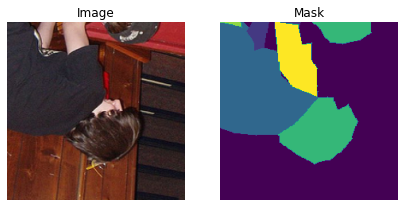

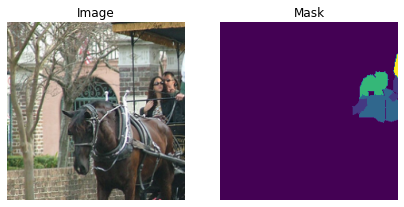

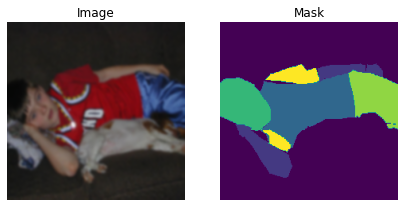

In [7]:
np.random.seed(42)
n_examples = 3
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

for i in range(n_examples):
    image, mask, mask_expanded = np.random.choice(train_dataset).values()
    image = image.permute(1, 2, 0)
    image = image * std + mean
    visualize(image=image, mask=mask)

In [8]:
num_epochs = 20
batch_size = 32
num_workers = 2
threshold = 0.5
logdir = "./logs/segmentation"

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
loaders = {
    "train": train_dataloader,
    "valid": val_dataloader
}
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "ce": nn.CrossEntropyLoss()
}
model = smp.Unet("resnet50", decoder_attention_type="scse", classes=7, activation=nn.Softmax2d)
optimizer = optim.Adam(
    (
        {
            "params": model.encoder.parameters(),
            "lr": 1e-4,
        },
        {
            "params": chain(model.decoder.parameters(), model.segmentation_head.parameters()),
            "lr" : 1e-2
        }
     )
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
callbacks = [
    CriterionCallback("pred", "mask_expanded", "loss_dice", "dice"),
    CriterionCallback("pred", "mask_expanded", "loss_iou", "iou"),
    CriterionCallback("pred", "mask", "loss_ce", "ce"),
    MetricAggregationCallback(
        "loss",
        {"loss_dice": 0.9, "loss_iou": 1.0, "loss_ce": 0.8},
        "weighted_sum"
        ),
    DiceCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    IOUCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    OptimizerCallback("loss")
]
runner = PascalRunner(input_key="image", output_key="pred",
                      output_mask_key="pred_mask", target_key="mask", 
                      device=device)

In [9]:
runner.train(
    loaders=loaders,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=callbacks,
    num_epochs=num_epochs,
    logdir=logdir,
    valid_loader="valid",
    valid_metric="iou",
    minimize_valid_metric=False
)

train (1/20) dice: 0.25483429431915283 | dice/_macro: 0.25483429431915283 | dice/_micro: 0.7712764739990234 | iou: 0.19971224665641785 | iou/_macro: 0.19971224665641785 | iou/_micro: 0.6277055144309998 | loss: 2.58003830909729 | loss_ce: 1.4139865241148581 | loss_ce/mean: 1.4139865241148581 | loss_ce/std: 0.09943385567028723 | loss_dice: 0.7307598622066287 | loss_dice/mean: 0.7307598622066287 | loss_dice/std: 0.07958429868727697 | loss_iou: 0.7911653022604132 | loss_iou/mean: 0.7911653022604132 | loss_iou/std: 0.06478056112768057 | lr: 0.0001 | momentum: 0.9
valid (1/20) dice: 0.3360705077648163 | dice/_macro: 0.3360705077648163 | dice/_micro: 0.8675155639648438 | iou: 0.28557002544403076 | iou/_macro: 0.28557002544403076 | iou/_micro: 0.766028642654419 | loss: 2.3196210861206055 | loss_ce: 1.3040574065698087 | loss_ce/mean: 1.3040574065698087 | loss_ce/std: 0.024625557988556007 | loss_dice: 0.6354837248146619 | loss_dice/mean: 0.6354837248146619 | loss_dice/std: 0.017372295498350843 |

In [10]:
csv_logger = Path(logdir) / "csv_logger"

train_df = pd.read_csv(csv_logger / "train.csv")
valid_df = pd.read_csv(csv_logger / "valid.csv")

Значения функции потерь и ключевой метрики во время обучения:

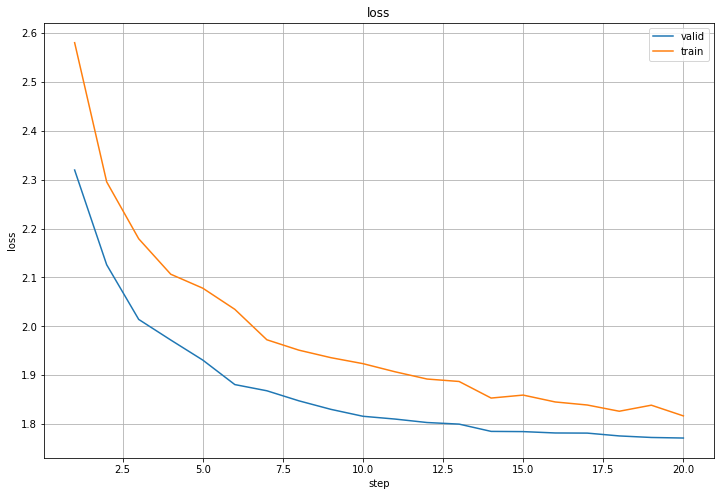

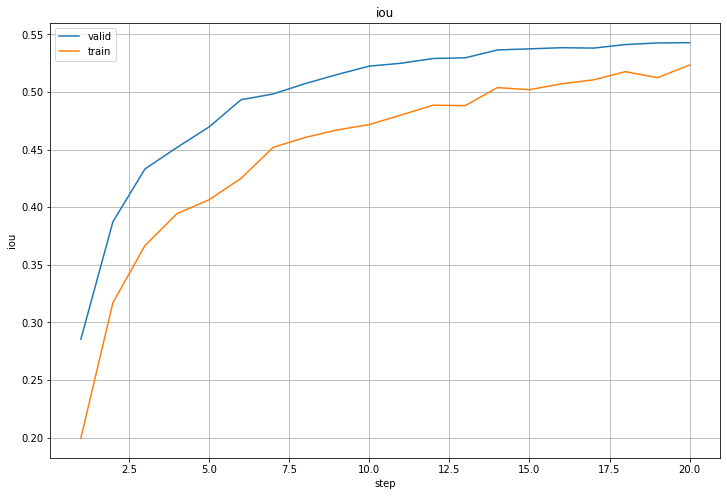

In [11]:
for metric_name in ["loss", "iou"]:
    plot_metric(train_df, valid_df, metric_name)

Почти на всем этапе обучение значение функции потерь уменьшается, а значение ключевой метрики увеличивается на обеих выборках.

Примеры исходных изображений и предсказаний модели на валидационной выборке:

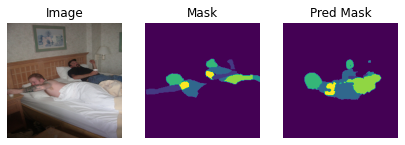

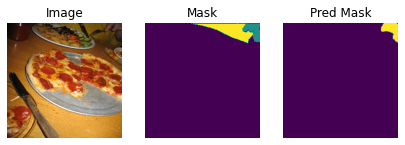

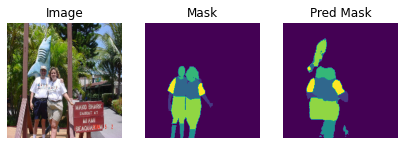

In [12]:
np.random.seed(42)

for i in range(n_examples):
    data = np.random.choice(val_dataset)
    dl = DataLoader([data])
    image, mask, mask_expanded = data.values()
    image = image.permute(1, 2, 0)
    image = image * std + mean
    pred_mask = torch.cat(list(runner.predict_loader(dl))).cpu().squeeze()
    visualize(image=image, mask=mask, pred_mask=pred_mask)

In [13]:
true_masks = torch.cat(list(extract_masks(val_dataloader))).to(device)
predicted_masks = torch.cat(list(runner.predict_loader(val_dataloader)))

In [14]:
body_labels = [[1, 6, 2, 4, 3, 5]]
up_low_labels = [[1, 6, 2, 4], [3, 5]]
parts_labels = list(range(1, n_classes))

true_masks0 = torch.stack(list(extract_masks_label(true_masks, body_labels)))
true_masks1 = torch.stack(list(extract_masks_label(true_masks, up_low_labels)))
true_masks2 = torch.stack(list(extract_masks_label(true_masks, parts_labels)))

predicted_masks0 = torch.stack(list(extract_masks_label(predicted_masks, body_labels)))
predicted_masks1 = torch.stack(list(extract_masks_label(predicted_masks, up_low_labels)))
predicted_masks2 = torch.stack(list(extract_masks_label(predicted_masks, parts_labels)))

Итоговые значения метрик на валидационной выборке:

In [15]:
iou0 = dict(zip(["body"], iou(true_masks0, predicted_masks0).cpu().numpy().round(3)))
pd.DataFrame(iou0, index=["iou0"])

,body
iou0,0.762


In [16]:
iou1 = dict(zip(["upper_body", "lower_body"], iou(true_masks1, predicted_masks1).cpu().numpy().round(3)))
pd.DataFrame(iou1, index=["iou1"])

,upper_body,lower_body
iou1,0.769,0.442


In [17]:
iou2 = dict(zip(classes[1:], iou(true_masks2, predicted_masks2).cpu().numpy().round(3)))
pd.DataFrame(iou2, index=["iou2"])

,low_hand,torso,low_leg,head,up_leg,up_hand
iou2,0.408,0.561,0.326,0.807,0.353,0.417


## Вывод:
Прироста в качестве модели так же не наблюдается.